In [1]:
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig
from trl import SFTTrainer

In [39]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [2]:
os.environ['HF_DATASETS_OFFLINE'] = '1'

In [17]:
base_model = "D:\LLM\models\Llama-2-7b-hf"

allocation_dataset = load_dataset("json", data_files={"train": "data/train.json", "test": "data/test.json"})


# allocation_dataset = load_dataset("./data", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [18]:
allocation_dataset

DatasetDict({
    train: Dataset({
        features: ['output', 'instruction', 'input'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['output', 'instruction', 'input'],
        num_rows: 200
    })
})

In [19]:
compute_dtype = getattr(torch, "float16")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)

In [20]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0}
)
model.config.use_cache = False
model.config.pretraining_tp = 1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [24]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model,
    add_eos_token=True,
    add_bos_token=True, 
)

In [25]:
def tokenize(prompt):
    result = tokenizer(prompt)
    result["labels"] = result["input_ids"].copy()
    return result

In [26]:
def generate_and_tokenize_prompt(data_point):
    full_prompt =f"""{data_point["instruction"]}

### Source fee:
{data_point["input"]}

### Target fees:
{data_point["output"]}
"""
    return tokenize(full_prompt)

In [30]:
tokenized_train_dataset = allocation_dataset["train"].map(generate_and_tokenize_prompt)
tokenized_test_dataset = allocation_dataset["test"].map(generate_and_tokenize_prompt)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [31]:
untokenized_text = tokenizer.decode(tokenized_test_dataset[1]['input_ids']) 
print(untokenized_text)

<s> do allocation for the given fee

### Source fee:
2-2-6-1-1-6-3-21778.55

### Target fees:
4-5-1-4-5-5-5-217.79;1-5-5-6-4-1-1-435.57;1-3-1-3-6-4-5-217.79;3-4-2-4-1-2-3-435.57;3-3-5-1-3-4-2-217.79;6-3-4-3-1-4-3-217.79;3-6-1-4-6-6-4-217.79;1-2-2-1-4-2-6-217.79;5-5-4-6-1-6-1-217.79;6-6-1-3-1-5-6-217.79;4-1-5-6-5-2-1-217.79;2-6-6-1-6-2-3-435.57;6-6-6-6-5-6-2-217.79;2-2-6-6-4-6-1-217.79;3-2-4-3-5-4-6-217.79;5-5-2-4-3-3-2-217.79;1-3-3-2-4-4-3-217.79;6-1-3-5-3-5-1-217.79;1-5-4-4-3-1-5-217.79;6-1-4-1-4-5-4-217.79;5-5-1-5-2-5-4-217.79;4-3-3-3-6-1-3-217.79;4-6-5-4-2-6-5-217.79;2-1-6-2-1-5-4-217.79;6-1-4-5-5-4-2-217.79;2-6-6-3-4-5-3-435.57;4-6-1-1-4-6-3-217.79;2-6-1-1-3-6-1-217.79;5-3-1-2-3-4-6-217.79;4-5-6-3-6-4-4-217.79;1-5-5-3-5-5-1-217.79;3-5-3-5-3-4-1-217.79;4-4-5-1-2-3-5-217.79;1-1-5-1-1-3-6-217.79;5-4-2-2-4-4-5-217.79;1-5-3-6-6-4-3-435.57;5-4-4-6-1-1-2-435.57;3-1-1-3-1-5-3-435.57;4-1-3-5-1-6-3-217.79;1-1-6-1-3-6-1-217.79;5-1-5-2-6-2-5-217.79;6-5-6-1-3-4-6-217.79;1-5-1-3-1-1-4-217.79;5-1

10200


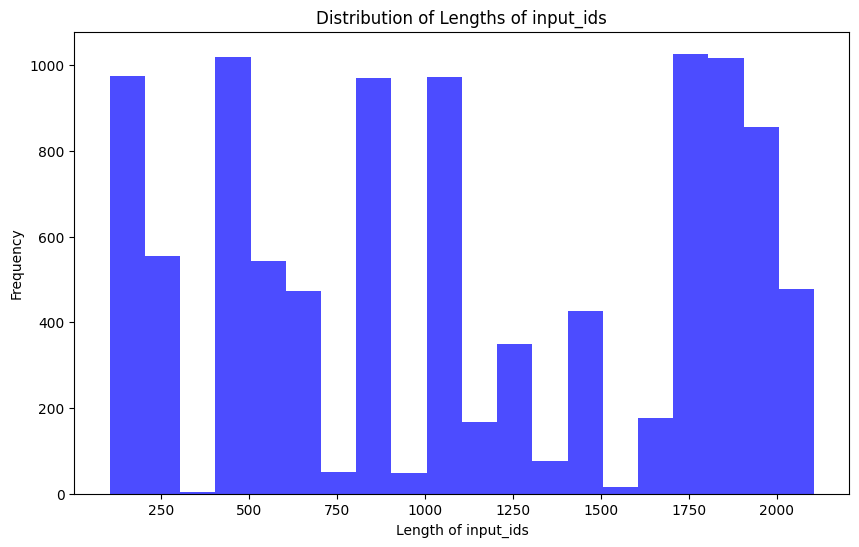

In [33]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_dataset_train, tokenized_dataset_test):
    lengths = [len(x['input_ids']) for x in tokenized_dataset_train]
    lengths += [len(x['input_ids']) for x in tokenized_dataset_test]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_test_dataset)

In [34]:
max_length = 2048 # This was an appropriate max length for my dataset

# redefine the tokenize function and tokenizer

tokenizer = AutoTokenizer.from_pretrained(
    base_model,
    padding_side="left",
    add_eos_token=True,  
    add_bos_token=True,  
)
tokenizer.pad_token = tokenizer.eos_token


def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [35]:
tokenized_train_dataset = allocation_dataset["train"].map(generate_and_tokenize_prompt)
tokenized_test_dataset = allocation_dataset["test"].map(generate_and_tokenize_prompt)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [36]:
print(tokenized_train_dataset[4]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 437, 24082, 363, 278, 2183, 27684, 13, 13, 2277, 29937, 7562, 27684, 29901, 13, 29906, 29899, 29906, 29899, 29953, 29899, 29896, 29899, 29896, 29899, 29953, 29899, 29941, 29899, 29953, 29947, 29941, 29

In [37]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [38]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [40]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

# Apply the accelerator. You can comment this out to remove the accelerator.
model = accelerator.prepare_model(model)

trainable params: 20277248 || all params: 3520690176 || trainable%: 0.5759452546613406


In [41]:
import transformers
from datetime import datetime

project = "capa"
base_model_name = "llama2-7b"
run_name = base_model_name + "-" + project
output_dir = "./result/" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=5,
        per_device_train_batch_size=2,
        gradient_checkpointing=True,
        gradient_accumulation_steps=4,
        max_steps=1000,
        learning_rate=2.5e-5,
        logging_steps=50,
        bf16=True,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        # report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

C:\Users\naych\miniconda3\envs\RuiwangTraining\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [42]:
trainer.train()

C:\Users\naych\miniconda3\envs\RuiwangTraining\Lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\naych\miniconda3\envs\RuiwangTraining\Lib\site-packages\transformers\models\llama\modeling_llama.py:670: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss
50,0.869400,0.773680


Step,Training Loss,Validation Loss
50,0.869400,0.773680


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


Step,Training Loss,Validation Loss
50,0.869400,0.773680
100,0.704200,0.717387
150,0.694400,0.675513
200,0.635200,0.590456
250,0.558000,0.498922
300,0.463600,0.404825
350,0.366500,0.323447
400,0.296800,0.258233
450,0.240900,0.207625
500,0.186500,0.171537


TrainOutput(global_step=1000, training_loss=0.29995553159713745, metrics={'train_runtime': 13578.9712, 'train_samples_per_second': 0.589, 'train_steps_per_second': 0.074, 'total_flos': 6.51521641414656e+17, 'train_loss': 0.29995553159713745, 'epoch': 0.8})

In [43]:
fine_tuned_model_dir = "fine_tuned/"
model.save_pretrained(fine_tuned_model_dir)
tokenizer.save_pretrained(fine_tuned_model_dir)

C:\Users\naych\miniconda3\envs\RuiwangTraining\Lib\site-packages\peft\utils\save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


('fine_tuned/tokenizer_config.json',
 'fine_tuned/special_tokens_map.json',
 'fine_tuned/tokenizer.model',
 'fine_tuned/added_tokens.json',
 'fine_tuned/tokenizer.json')